# Some Simple Spin Glasses

We'll now investigate some simple spin glasses. Our goal is to devise a thermal annealing schedule to find the ground state of the given Ising Hamiltonian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common.ising_animator import IsingAnimator
from common.abstract_ising import AbstractIsing
from common.utils import *

%matplotlib inline

## 1D Random Bond Ising on a Periodic Chain

The hamiltonian of this model is given by

$$H = J \sum_{\langle ij \rangle} B_{ij} \sigma_i \sigma_j$$

where $J$ is a constant, $\langle ij\rangle$ denotes nearest neigbor pairs and $B_{ij} = \pm 1$ which is selected randomly and independently for each bond nearest neighbour bond $\langle ij\rangle$ when the model is initialized. Note, that the first and the last spins in the chain are considered nearest neigbors, since we are looking at a _Periodic Boundary Condition (PBC)_ model. Due to the intrinsic randomness of the Hamiltonian parameters, it is generally quite difficult to find the ground state of this model. 

Below, we define a class called `RandomBondIsing1DPBC` to model this problem.

In [2]:
class RandomBondIsing1DPBC(AbstractIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        self.bonds = 2*(np.random.rand(self.N) < 0.5) - 1
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
    def energy(self, spins=None):
        """Returns the energy of the current spin configuration"""
        spins = self.spins if spins is None else spins
        interactions = self.bonds * spins * np.roll(spins, 1, axis=-1)
        total = self.J * np.sum(interactions, axis=-1)
        return total

    def energy_diff(self, i):
        """Returns the energy difference resulting from flipping the i'th site"""
        # sum the nearest neighbour sites
        
        nn_sum = (
            self.bonds[i] * self.spins[i-1] 
            + self.bonds[(i+1)%self.N] * self.spins[(i+1) % self.N] 
        )

        return -2 * self.J * self.spins[i] * nn_sum
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.N),)
    
    def all_configurations(self):
        """Returns all possible spin configurations"""
        dim = np.arange(2 ** self.num_spins)
        space = ((dim[:, None] & (1 << np.arange(self.num_spins))) > 0)
        space = 2*space.astype(int) - 1
        return space

In [4]:
ising = RandomBondIsing1DPBC(10, J=1)
print("Spins: ", ising.spins)
print("Bonds: ", ising.bonds)
print("Energy: ", ising.energy())

Spins:  [-1 -1 -1  1  1  1 -1  1 -1 -1]
Bonds:  [ 1 -1  1  1 -1 -1  1  1 -1  1]
Energy:  -2


Let us run MC simulation at a fixed temperature ($T=1.0$) for 1000 iterations, and see what spin configuration the algorithm converges to

In [5]:
T = 1.0
n_steps = 1000

In [6]:
for t in range(n_steps):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print("Iteration %i, Energy=%f" % (t, E))
        
print("The final spin configuration: ", ising.spins)
print("The energy of the configuration: ", ising.energy())

Iteration 0, Energy=-6
Iteration 50, Energy=-6
Iteration 100, Energy=-6
Iteration 150, Energy=-6
Iteration 200, Energy=-10
Iteration 250, Energy=-6
Iteration 300, Energy=-6
Iteration 350, Energy=-10
Iteration 400, Energy=-10
Iteration 450, Energy=-6
Iteration 500, Energy=-10
Iteration 550, Energy=-6
Iteration 600, Energy=-10
Iteration 650, Energy=-6
Iteration 700, Energy=-6
Iteration 750, Energy=-6
Iteration 800, Energy=-6
Iteration 850, Energy=-6
Iteration 900, Energy=-10
Iteration 950, Energy=-10
The final spin configuration:  [ 1  1 -1  1  1  1 -1  1 -1  1]
The energy of the configuration:  -6


Let us now run the MC simulation for fixed temperature ($T=1.0$) for 1000 iterations once again, but this time using our `IsingAnimator` functionality, so that we can animate the evolution

[-1 -1  1  1  1 -1 -1 -1  1  1]


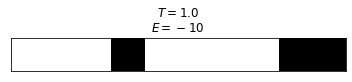

In [7]:
# reinitialize so we're back at a T=infinity state
ising = RandomBondIsing1DPBC(10, J=1)
print(ising.spins)  # print the starting configuration

# NOTE: sometimes the animation gets stuck displaying a single image
# The most reliable way to fix this is by restarting the notebook.
# Initializing the Ising Model in the same cell as the one where you
# run the animation also seems to work.
IsingAnimator(ising).run_animation([T] * n_steps)

Since the spin chain we have considered so far in this notebook is small (only 10 spins), instead of simulated annealing, we can do exact computation and find the exact minimal energy. For this purpose we need to calculate the energy of the chain for all possible spin configurations and pick the one(s) which give the lowest energy. 

The class `RandomBondIsing1DPBC` has a function called `all_configurations()`, which returns the list of all possible spin configurations for this model. The `energy()` function of the class is written in a way, that it can calculate energies of a list of configurations passed as argument. Let us use these functions to _exactly_ calculate the minimum energy of the system. As we can see, the minimal energy found by the annealing procedure above coincides with the exact minimum:

In [8]:
ising.energy(ising.all_configurations()).min()

-10

To help visualise the distribution of various spin configurations and energies, let us plot the energies of all configuration. As we can see, there are only two spin configurations with globally minimal energy (NOTE: this claim may change, if you rerun the codes, since the model is random), and our thermal annealing procedure has successfully found one of them.

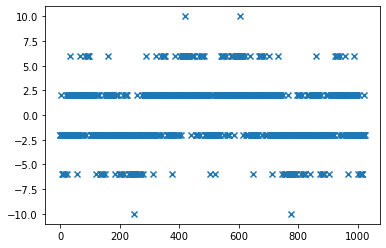

In [9]:
# plot the energy of all configurations
configurations = ising.all_configurations()
energies = ising.energy(configurations)
plt.scatter(np.arange(2 **ising.num_spins), energies, marker='x')
plt.show()

Now of course, we're limited in the size of the systems for which we can compute this energy exactly. For a spin chain with $N$ spins, the number of all possible spin configurations is $2^{N}$, hence if we increase the number of spins in the chain, the number of spin configurations to check for exact solution grows exponentially. Hence why we need an annealing procedure which (we hope) would help us find the ground state of the Ising model of interest (or at least a state that is close enough).

Let us come up with an annealing procedure to help find the ground state (or something close enough) of this model for several different chain sizes: 10, 20, 50, 100.

For the small systems, we can compute the ground state energy exactly, and compare it to the result of your annealer.

Since it's impossible to find the exact ground state for large systems, you will be evaluated on your algorithm's performance on the small systems, as well as the overall ingenuity of your method.

There are several ways to modify the annealing framework we have developed so far, to make it better, and able to find global minimum of large systems. One way is to improve the temperature decay schedule (i.e. the sequence of temperature updates). Another way is to alter the `mc_step` functionality. In particular, instead of using the Gibbs probabilities to decide whether or not to choos the new configuration, we can use other probability distributions as well. Below, we will look closely at different decay schedules and try to find something which works the best. We will not alter the `mc_step` functionality, since we want to remain within the thermal annealing framework throughout this project.

### Decay schedules

In the previous notebook we introduced the exponential time decay schedule for annealing. Let us introduce a few other forms of schedules and try understand which schedule works best for the random bond model considered here. We have implemented the functions to generate various decay schedules  under `common/utils.py`. Below we have demonstrated 4 different schedules - exponential, hyperbolic, linear, polynomial. 

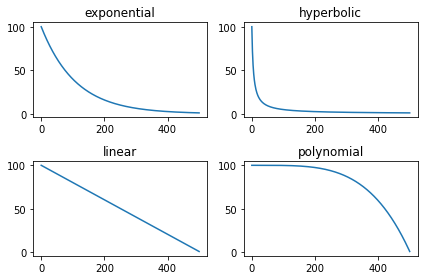

In [10]:
N, Ti, Tf = 500, 100, 1
fig, axs = plt.subplots(2, 2)

# exponential decay schedule
T, time = exp_decay_schedule(N, Ti, Tf)
axs[0, 0].plot(time, T)
axs[0, 0].set_title("exponential")

# hyperbolic decay schedule
T, time = inv_decay_schedule(N, Ti, Tf)
axs[0, 1].plot(time, T)
axs[0, 1].set_title("hyperbolic")

# linear decay schedule
T, time = lin_decay_schedule(N, Ti, Tf)
axs[1, 0].plot(time, T)
axs[1, 0].set_title("linear")

# polynomial decay schedule
T, time = poly_decay_schedule(N, Ti, Tf, degree=4)
axs[1, 1].plot(time, T)
axs[1, 1].set_title("polynomial")

fig.tight_layout()
plt.show()

A prominent feature of the exponential decay schedule, as seen from the plot above, is that at the beginning the temperature is lowered rapidly with each step, however at the end it approaches the final temperature asymptotically. Due to this you spend small number of iterations on the initial high-temperature simulations and quickly go to the region of lower temperatures.

Another schedule similar to the exponential decay schedule in this regard is the inverse-time decay schedule (hyperbolic). We can see, that for given starting and final temperatures the hyperbolic schedule decays extremely quickly (quicker than the exponential schedule) in the beginning and levels off very early. 

A decay schedule, which decreases the temperature by the same amount at all stages is the linear decay schedule.

We also introduce decay schedules based on higher order polynomials of the form $ax^n+b$. Such a schedule for fourth degree polynomial is depicted at the lower right corner of the figure above. The main characteristic difference of these schedules compared to exponential and inverse time schedules is that here the temperature decreases slowly at the begining, and faster at the end.

We aslo introduce an interesting feature for the decay schedules - oscillations. All the different kinds of schedules introduced above decrease the temperature monotonically from initial to final. Under `common/utils.py` we have implemented a function called `osc_decay_schedule`, which takes a schedule generated with the functions introduced above, and adds oscillations to them (amplitude and frequency of oscillations are controled by the arguments `a` and `b`). The oscillations will make the algorithm to go back to higher temperatures from time to time with the hope to enhance the finding of global minimum. The contributions of oscillations becomes smaller and smaller as we approach the end temperature. Let us depict the oscilating versions of the four schedules plotted above

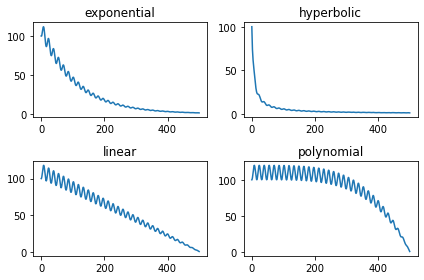

In [11]:
N, Ti, Tf = 500, 100, 1
a, b = 0.2, N / 5
fig, axs = plt.subplots(2, 2)

# exponential decay schedule
T, time = osc_decay_schedule(*exp_decay_schedule(N, Ti, Tf), a, b)
axs[0, 0].plot(time, T)
axs[0, 0].set_title("exponential")

# hyperbolic decay schedule
T, time = osc_decay_schedule(*inv_decay_schedule(N, Ti, Tf), a, b)
axs[0, 1].plot(time, T)
axs[0, 1].set_title("hyperbolic")

# linear decay schedule
T, time = osc_decay_schedule(*lin_decay_schedule(N, Ti, Tf), a, b)
axs[1, 0].plot(time, T)
axs[1, 0].set_title("linear")

# polynomial decay schedule
T, time = osc_decay_schedule(*poly_decay_schedule(N, Ti, Tf, degree=4), a, b)
axs[1, 1].plot(time, T)
axs[1, 1].set_title("polynomial")

fig.tight_layout()
plt.show()

Now let us run annealing against the eight different decay schedules defined above, for random chains of different lengths, and see what works best. Under `common/utils.py` we have implemented a small wrapper function `anneal`, which takes an ising model and a decay schedule, carries out the annealing and returns the lowest energy found and the correponding spin configuration. This function also has one additional parameter (`mc_steps`) to control the number of MC steps at each temperature. In the previous notebook, while animating an annealing process, we used only one MC step at each temperature (take a look at `common/ising_animator.py` for the implementation details). However for larger and larger system sizes this approach may not be good enough, since at each MC step the Metropolis-Hastings algorithm flips only one spin (chosen randomly), and if the system size is large, this one flip may not be able to reveal the actual state of the afairs. One approach would be to set this parameter equal to the size of the system, so that the algorithm attempts to flip all the spins (in average), however this increases the order of the complexity of the algorithm, and we are not interested in it. What we will do instead, is use constant number of MC steps at each temperature, regardless the system size, and see which one of the decay schedules performes best under this circumstance.

In [55]:
from copy import deepcopy

def benchmark_schedules(ising_class, sizes, scheds):
    runs = 1  # number of end-to-end annealing procedures to be done for each size and schedule

    for size in sizes:
        ising = ising_class(size, J=1.)
        if size <= 20:
            energy = ising.energy(ising.all_configurations()).min()
            print("Model of size %i, exact calculation. Minimum energy found: %f" % (size, energy))
        for name, sched in scheds.items():
            for _ in range(runs):
                ising_cp = deepcopy(ising)  # work on a copy to keep the original
                energy, _ = anneal(ising_cp, sched[0], 1)
                print("Model of size %i, with %s schedule. Energy found: %f" % (size, name, energy))
        
N, ti, Tf = 500, 100, 0.01
exp_sched = exp_decay_schedule(N, Ti, Tf)
hyp_sched = inv_decay_schedule(N, Ti, Tf)
lin_sched = lin_decay_schedule(N, Ti, Tf)
pol_sched = poly_decay_schedule(N, Ti, Tf, degree=2)

a, b = 0.2, N / 5
exp_sched_osc = osc_decay_schedule(*exp_sched, a, b)
hyp_sched_osc = osc_decay_schedule(*hyp_sched, a, b)
lin_sched_osc = osc_decay_schedule(*lin_sched, a, b)
pol_sched_osc = osc_decay_schedule(*pol_sched, a, b)

scheds = {"exponential": exp_sched, 
              "hyperbolic": hyp_sched, 
              "linear": lin_sched, 
              "polynomial": pol_sched, 
              "oscillating exponential": exp_sched_osc, 
              "oscillating hyperbolic": hyp_sched_osc, 
              "oscillating linear": lin_sched_osc, 
              "oscillating polynomial": pol_sched_osc}

benchmark_schedules(RandomBondIsing1DPBC, [10, 15, 20, 50, 100], scheds)

Model of size 10, exact calculation. Minimum energy found: -10.000000
Model of size 10, with exponential schedule. Energy found: -10.000000
Model of size 10, with hyperbolic schedule. Energy found: -10.000000
Model of size 10, with linear schedule. Energy found: -10.000000
Model of size 10, with polynomial schedule. Energy found: -10.000000
Model of size 10, with oscillating exponential schedule. Energy found: -10.000000
Model of size 10, with oscillating hyperbolic schedule. Energy found: -10.000000
Model of size 10, with oscillating linear schedule. Energy found: -10.000000
Model of size 10, with oscillating polynomial schedule. Energy found: -6.000000
Model of size 15, exact calculation. Minimum energy found: -15.000000
Model of size 15, with exponential schedule. Energy found: -15.000000
Model of size 15, with hyperbolic schedule. Energy found: -15.000000
Model of size 15, with linear schedule. Energy found: -11.000000
Model of size 15, with polynomial schedule. Energy found: -11.0

We see, that for smaller models generally all schedules do well. However, for larger ones the linear and polynomial schedules tend to perform bad. The takeaway message is, that it is important to relatively quickly decrease the temperature at the beginning and level off. By doing this, we essentially make the algorithm run many iterations at very close temperatures, and accomplish something similar as we would have achieved by running large number of MC steps at each temperature.

After executing for a few different parameter configurations, we noticed, that sometimes the hyperbolic and the oscillating exponential schedules perform better, than the exponential one. The good part of the hyperbolic schedule is that it spends a lot of time in the leveled-off region, however the bad part is that it levels off too quickly making it possible to miss the global minimum at the beginning. So, let us build a hybrid schedule, which consists of two parts - at the begining it is hyperbolic, lowering the temperature rapidly compared to the end-to-end exponential schedule, and mildly compared to end-to-end hyperbolic. Then it transforms into linear and goes til the end. The comparison of such a schedule with exponential and hyperbolic is shown below, where the black curve is end-to-end exponential, the blue curve is the hyperbolic, and the red curve is the hybrid curve as described.

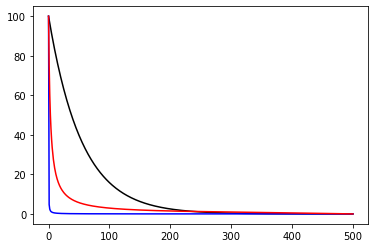

In [39]:
def hybrid_decay_schedule(N, Ti, Tf, switch_at=1, ratio=0.2):
    T1, time1 = inv_decay_schedule(ratio * N, Ti, switch_at)
    T2, time2 = lin_decay_schedule((1 - ratio) * N, switch_at, Tf)
    return (np.append(T1, T2), np.append(time1, ratio * N + time2))

T, time = exp_decay_schedule(500, 100, 0.01)
plt.plot(time, T, color='black')

T, time = inv_decay_schedule(500, 100, 0.01)
plt.plot(time, T, color='blue')

T, time = hybrid_decay_schedule(500, 100, 0.01, ratio=0.6)
plt.plot(time, T, color='red')

plt.show()

Let us now benchmark this new hybrid schedule with the others as well.

In [89]:
scheds['hybrid'] = hybrid_decay_schedule(N, Ti, Tf, ratio=0.05)
benchmark_schedules(RandomBondIsing1DPBC, [10, 15, 20, 50, 100], scheds)

Model of size 10, exact calculation. Minimum energy found: -10.000000
Model of size 10, with exponential schedule. Energy found: -10.000000
Model of size 10, with hyperbolic schedule. Energy found: -10.000000
Model of size 10, with linear schedule. Energy found: -10.000000
Model of size 10, with polynomial schedule. Energy found: -10.000000
Model of size 10, with oscillating exponential schedule. Energy found: -10.000000
Model of size 10, with oscillating hyperbolic schedule. Energy found: -10.000000
Model of size 10, with oscillating linear schedule. Energy found: -10.000000
Model of size 10, with oscillating polynomial schedule. Energy found: -6.000000
Model of size 10, with hybrid schedule. Energy found: -10.000000
Model of size 15, exact calculation. Minimum energy found: -13.000000
Model of size 15, with exponential schedule. Energy found: -13.000000
Model of size 15, with hyperbolic schedule. Energy found: -13.000000
Model of size 15, with linear schedule. Energy found: -9.000000

As we can see, the new hybrid schedule gives promissing results. Let us use this schedule to animate the annealing process for our random bond ising model

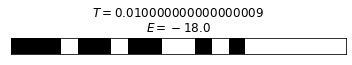

In [90]:
# your solution here
ising = RandomBondIsing1DPBC(20, J=1.)

T, _ = hybrid_decay_schedule(500, 100, 0.01, ratio=0.05)
animator = IsingAnimator(ising)
animator.run_animation(T)

In [91]:
# get exact minimum
ising.energy(ising.all_configurations()).min()

-18.0

# Fully Connected Random Bond Ising

The Fully Connected Random Bond Ising Hamiltonian takes the form:

$$H = J \sum_{i<j} B_{ij} \sigma_i \sigma_j$$

where $J$ is a constant and $B_{ij} = \pm 1$ which is selected randomly (uniformly) and independently for each bond $ij$ when the model is initialized. Note that in this model the summation goes over all posible spin pairs, not only the nearest neigbors, which is why the model is called fully connected.

In [2]:
class FullyConnectedRandomBondIsing(AbstractIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
        self.bonds = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.bonds[i, j] = 2*(np.random.rand() < 0.5) - 1
    
    def energy(self, spins=None):
        """Returns the energy of the current spin configuration, or given spin configurations"""
        if spins is None:
            spins = self.spins
        
        if len(spins.shape) == 1:
            spins = spins[None, :]
        
        return np.einsum("bi,ij,bj->b", spins, self.bonds, spins)

    def energy_diff(self, i):
        """Returns the energy difference resulting from flipping the i'th site"""
        de =  -2 * self.J * self.spins[i] * (
            self.bonds[i, :].dot(self.spins) 
            + self.bonds[:, i].dot(self.spins)
        )
        
        return de
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.N),)
    
    def all_configurations(self):
        """Returns all possible spin configurations"""
        dim = np.arange(2 ** self.num_spins)
        space = ((dim[:, None] & (1 << np.arange(self.num_spins))) > 0)
        space = 2*space.astype(int) - 1
        return space

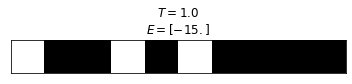

In [106]:
ising = FullyConnectedRandomBondIsing(10, J=1)
# print("Spins: ", ising.spins)
# print("Bonds: ", ising.bonds)
# print("Energy: ", ising.energy())

T = 1.0
n_steps = 1000
IsingAnimator(ising).run_animation([T] * n_steps)

In [107]:
# get the exact minimum
ising.energy(ising.all_configurations()).min()

-19.0

Let us benchmark the various temperature decay schedules introduced above, for this model as well

In [105]:
benchmark_schedules(FullyConnectedRandomBondIsing, [10, 15, 20, 50, 100], scheds)

Model of size 10, exact calculation. Minimum energy found: -17.000000
Model of size 10, with exponential schedule. Energy found: -17.000000
Model of size 10, with hyperbolic schedule. Energy found: -17.000000
Model of size 10, with linear schedule. Energy found: -15.000000
Model of size 10, with polynomial schedule. Energy found: -13.000000
Model of size 10, with oscillating exponential schedule. Energy found: -17.000000
Model of size 10, with oscillating hyperbolic schedule. Energy found: -17.000000
Model of size 10, with oscillating linear schedule. Energy found: -15.000000
Model of size 10, with oscillating polynomial schedule. Energy found: -15.000000
Model of size 10, with hybrid schedule. Energy found: -17.000000
Model of size 15, exact calculation. Minimum energy found: -39.000000
Model of size 15, with exponential schedule. Energy found: -39.000000
Model of size 15, with hyperbolic schedule. Energy found: -39.000000
Model of size 15, with linear schedule. Energy found: -39.0000

For this model, it looks like the exponential decay schedule is the best. Let us animate the annealing procedure for this schedule

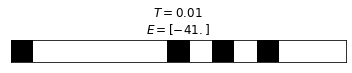

In [108]:
# your solution here
ising = FullyConnectedRandomBondIsing(15, J=1.)

T, _ = exp_decay_schedule(500, 100, 0.01)
animator = IsingAnimator(ising)
animator.run_animation(T)

In [109]:
# get the exact minimum
ising.energy(ising.all_configurations()).min()

-41.0

# The Fully Connected Mattis Model

Another model of interest is the Mattis Model which is a specific instance of a Random Bond Ising Model:

$$H = J\sum_{i<j} B_{ij}\sigma_i\sigma_j$$

however, the random bonds take the form:

$$B_{ij} = -\xi_i \xi_j$$

where $\xi_i = \pm 1$ with the sign selected randomly (uniformly) when the model is initialized.

In [3]:
class FullyConnectedMattisModel(FullyConnectedRandomBondIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        self.xi = 2*(np.random.rand(self.N) < 0.5) - 1
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
        self.bonds = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.bonds[i, j] = -self.xi[i] * self.xi[j]
    

In [4]:
ising = FullyConnectedMattisModel(10, J=1)
print("spins: ", ising.spins)
print("bonds: ", ising.bonds)
print("energy: ", ising.energy())

spins:  [ 1  1  1  1 -1  1  1 -1 -1  1]
bonds:  [[ 0. -1. -1.  1.  1. -1. -1.  1.  1.  1.]
 [ 0.  0. -1.  1.  1. -1. -1.  1.  1.  1.]
 [ 0.  0.  0.  1.  1. -1. -1.  1.  1.  1.]
 [ 0.  0.  0.  0. -1.  1.  1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  1.  1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
energy:  [-13.]


In [6]:
T = 0.1
# perform 1000 MC steps at low temperature to find the ground state
# it's fairly easy to find in this case as we'll discuss soon
for t in range(1000+1):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print("Iteration %i, Energy=%f" % (t, E))

Iteration 0, Energy=-45.000000
Iteration 50, Energy=-45.000000
Iteration 100, Energy=-45.000000
Iteration 150, Energy=-45.000000
Iteration 200, Energy=-45.000000
Iteration 250, Energy=-45.000000
Iteration 300, Energy=-45.000000
Iteration 350, Energy=-45.000000
Iteration 400, Energy=-45.000000
Iteration 450, Energy=-45.000000
Iteration 500, Energy=-45.000000
Iteration 550, Energy=-45.000000
Iteration 600, Energy=-45.000000
Iteration 650, Energy=-45.000000
Iteration 700, Energy=-45.000000
Iteration 750, Energy=-45.000000
Iteration 800, Energy=-45.000000
Iteration 850, Energy=-45.000000
Iteration 900, Energy=-45.000000
Iteration 950, Energy=-45.000000
Iteration 1000, Energy=-45.000000


In [7]:
# get the exact minimum
ising.energy(ising.all_configurations()).min()

-45.0

While at first glance the `bonds` matrix for the Mattis Model appears to produce the glassy model, it is in fact not a glass at all. We can convert this into a simple fully connected Ising Model using a *gauge transformation*.
But first, make sure the MC simulation has converged to the ground state energy we computed exactly in the previous cell. If it hasn't done so yet, let it run a few more times.

Now let's look at our ground state spin configuration:

In [121]:
ising.spins

array([ 1,  1, -1, -1,  1,  1, -1, -1, -1,  1])

Next we'll look at the Mattis parameters $\xi$

In [122]:
ising.xi

array([-1, -1,  1,  1, -1, -1,  1,  1,  1, -1])

If we did indeed find the ground state, the spins should match with $\xi$ (upto a global sign). This gives us a hint as to what this Mattis Model actually is.

Let's look again at the Hamiltonian:

$$H = J \sum_{i<j} B_{ij} \sigma_i \sigma_j = -J\sum_{i < j} \xi_i \xi_j \sigma_i \sigma_j = -J\sum_{i < j} (\xi_i \sigma_i) (\xi_j\sigma_j)$$

We introduce some new variables $s_i = \xi_i \sigma_i \in \lbrace 0, 1 \rbrace$. Then our Hamiltonian becomes:

$$H = -J \sum_{i < j} s_i s_j$$

which is just a fully connected Ising Model - basically a ferromagnetic model for the binary variables $s_i$, hence for $s_i$ we expect to be either all ones, or all minus ones. If we compute $s_i$ for the state found in the previous simulation, we get:

In [28]:
ising.spins * ising.xi

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

which is one of the ground states of the fully connected Ising Model.

Let us apply the annealing algorithm we have developed in the two previous parts to this model to the fully connected Mattis model with exponential decay schedule. We will use exponential temperature decay schedule. 

At the end of the annealing procedure we will confirm that we've found the ground state by checking that $\xi_i$ is equal to $\sigma_i$ upto a global sign, i.e. if we we multiply the spin configuration elementwise with $\xi$, we will get all ones, or all minus ones.

In [8]:
ising = FullyConnectedMattisModel(10, J=1)

sched = exp_decay_schedule(500, 100, 0.01)[0]
anneal(ising, sched)

(array([-45.]), array([ 1, -1, -1,  1,  1, -1, -1,  1, -1,  1]))

In [9]:
ising.xi * ising.spins

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])